# CIFAR-10 图像分类实验

本实验基于Scoring Criteria 2，在CIFAR-10数据集上实验5个改进因子来提升图像分类性能。

## 实验设计

### 基线模型
- 基于Example.ipynb的简单CNN架构
- 预期准确率：~86.5%

### 5个改进因子
1. **残差连接** - 解决梯度消失问题
2. **更深/更宽的网络架构** - 增加模型容量
3. **更好的优化器和学习率调度** - 提升训练效果
4. **高级数据增强** - MixUp, CutMix
5. **注意力机制** - SE Attention

### 实验流程
1. 基线模型训练和评估
2. 逐个添加改进因子，记录性能变化
3. 分析每个因子的贡献
4. 组合最佳因子进行最终实验


In [41]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import time
import os

# 导入自定义模块
from models import get_model
from dataset_utils import get_dataset_loaders
from training_utils import (
    train_model, get_optimizer, get_scheduler, 
    get_optimizer_config, get_scheduler_config
)
from data_augmentation import get_transforms

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设备配置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")


使用设备: cuda:0


## 实验配置


In [42]:
# 实验配置
config = {
    'dataset': 'cifar10',
    'batch_size': 64,
    'num_workers': 4,
    'num_epochs': 50,  # 为了快速实验，减少epoch数
    'print_every': 1,  # 这里print的是epoch
}

# 模型配置
models_to_test = [
    'baseline',          # 基线模型
    'residual',          # 改进因子(a): 残差连接
    'deeper_wider',      # 改进因子(b): 更深更宽网络
    'se_attention',    # 改进因子(e): 自注意力
]

# 优化器配置 - 改进因子(c)
optimizer_configs = {
    'Adam': {'optimizer': 'Adam', 'scheduler': None},
    'AdamW': {'optimizer': 'AdamW', 'scheduler': 'cosine'},
    'RMSprop': {'optimizer': 'RMSprop', 'scheduler': 'cosine'},
}

# 数据增强配置 - 改进因子(d)
augmentation_configs = {
    'basic': 'basic',
    'mixup': 'mixup',
    'cutmix': 'cutmix',
}

print("实验配置完成")


实验配置完成


## 1. 基线模型实验


In [15]:
# 加载数据
train_loader, test_loader, num_classes = get_dataset_loaders(
    config['dataset'], 
    batch_size=config['batch_size'],
    num_workers=config['num_workers'],
    augmentation_type='basic'
)

print(f"数据集: {config['dataset']}")
print(f"类别数: {num_classes}")
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")


数据集: cifar10
类别数: 10
训练集大小: 50000
测试集大小: 10000


In [43]:
# 基线模型实验
print("=== 基线模型实验 ===")

# 创建基线模型
baseline_model = get_model('baseline', num_classes).to(device)

# 配置优化器
optimizer_config = get_optimizer_config('Adam')
optimizer = get_optimizer(baseline_model, 'Adam', **optimizer_config)

# 损失函数
criterion = nn.CrossEntropyLoss()

# 训练模型
baseline_history = train_model(
    baseline_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

print(f"基线模型最终测试准确率: {max(baseline_history['test_acc']):.2f}%")


=== 基线模型实验 ===
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 7.28M


Epoch   1/50: Train Loss: 1.9644, Train Acc: 22.87%, Test Loss: 1.7134, Test Acc: 33.35%, LR: 0.001000, Time: 3.11s
Epoch   2/50: Train Loss: 1.7033, Train Acc: 34.77%, Test Loss: 1.4638, Test Acc: 43.66%, LR: 0.001000, Time: 3.38s
Epoch   3/50: Train Loss: 1.5605, Train Acc: 42.30%, Test Loss: 1.3603, Test Acc: 49.62%, LR: 0.001000, Time: 3.23s
Epoch   4/50: Train Loss: 1.4730, Train Acc: 46.71%, Test Loss: 1.2748, Test Acc: 54.14%, LR: 0.001000, Time: 3.20s
Epoch   5/50: Train Loss: 1.4151, Train Acc: 49.24%, Test Loss: 1.2145, Test Acc: 55.55%, LR: 0.001000, Time: 3.11s
Epoch   6/50: Train Loss: 1.3754, Train Acc: 51.11%, Test Loss: 1.1704, Test Acc: 58.14%, LR: 0.001000, Time: 3.23s
Epoch   7/50: Train Loss: 1.3481, Train Acc: 52.61%, Test Loss: 1.1128, Test Acc: 60.81%, LR: 0.001000, Time: 3.31s
Epoch   8/50: Train Loss: 1.3227, Train Acc: 53.66%, Test Loss: 1.1121, Test Acc: 60.87%, LR: 0.001000, Time: 3.73s
Epoch   9/50: Train Loss: 1.2918, Train Acc: 54.90%, Test Loss: 1.1087, 

## 2. 改进因子实验

### 2.1 残差连接机制 (改进因子a)


In [44]:
print("=== 改进因子(a): 残差连接机制 ===")

# 创建带残差连接的模型
residual_model = get_model('residual', num_classes).to(device)

# 使用baseline优化器配置
optimizer = get_optimizer(residual_model, 'Adam', **optimizer_config)

# 训练模型
residual_history = train_model(
    residual_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

print(f"残差模型最终测试准确率: {max(residual_history['test_acc']):.2f}%")
print(f"相比基线提升: {max(residual_history['test_acc']) - max(baseline_history['test_acc']):.2f}%")


=== 改进因子(a): 残差连接机制 ===
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 4.83M
Epoch   1/50: Train Loss: 1.3921, Train Acc: 49.22%, Test Loss: 1.1396, Test Acc: 59.94%, LR: 0.001000, Time: 3.32s
Epoch   2/50: Train Loss: 1.0194, Train Acc: 63.63%, Test Loss: 0.9309, Test Acc: 67.31%, LR: 0.001000, Time: 3.30s
Epoch   3/50: Train Loss: 0.8585, Train Acc: 69.77%, Test Loss: 0.8083, Test Acc: 72.27%, LR: 0.001000, Time: 3.11s
Epoch   4/50: Train Loss: 0.7545, Train Acc: 73.65%, Test Loss: 0.7704, Test Acc: 73.66%, LR: 0.001000, Time: 2.95s
Epoch   5/50: Train Loss: 0.6877, Train Acc: 75.90%, Test Loss: 0.6880, Test Acc: 76.32%, LR: 0.001000, Time: 3.03s
Epoch   6/50: Train Loss: 0.6377, Train Acc: 77.66%, Test Loss: 0.5890, Test Acc: 79.71%, LR: 0.001000, Time: 3.03s
Epoch   7/50: Train Loss: 0.5967, Train Acc: 79.53%, Test Loss: 0.5675, Test Acc: 80.69%, LR: 0.001000, Time: 3.11s
Epoch   8/50: Train Loss: 0.5606, Train Acc: 80.65%, Test Loss: 0.5409, Test Acc:

Epoch  15/50: Train Loss: 0.4208, Train Acc: 85.43%, Test Loss: 0.4504, Test Acc: 84.78%, LR: 0.001000, Time: 2.92s
Epoch  16/50: Train Loss: 0.4118, Train Acc: 85.66%, Test Loss: 0.4173, Test Acc: 85.69%, LR: 0.001000, Time: 3.07s
Epoch  17/50: Train Loss: 0.4026, Train Acc: 86.00%, Test Loss: 0.4350, Test Acc: 85.63%, LR: 0.001000, Time: 3.01s
Epoch  18/50: Train Loss: 0.3936, Train Acc: 86.23%, Test Loss: 0.3870, Test Acc: 86.98%, LR: 0.001000, Time: 3.06s
Epoch  19/50: Train Loss: 0.3820, Train Acc: 86.73%, Test Loss: 0.4061, Test Acc: 86.79%, LR: 0.001000, Time: 2.96s
Epoch  20/50: Train Loss: 0.3762, Train Acc: 87.08%, Test Loss: 0.3951, Test Acc: 86.93%, LR: 0.001000, Time: 3.19s
Epoch  21/50: Train Loss: 0.3682, Train Acc: 87.14%, Test Loss: 0.4558, Test Acc: 84.73%, LR: 0.001000, Time: 3.18s
Epoch  22/50: Train Loss: 0.3664, Train Acc: 87.22%, Test Loss: 0.3903, Test Acc: 86.99%, LR: 0.001000, Time: 3.10s
Epoch  23/50: Train Loss: 0.3547, Train Acc: 87.63%, Test Loss: 0.3833, 

### 2.2 更深更宽的网络架构 (改进因子b)


In [45]:
print("=== 改进因子(b): 更深更宽的网络架构 ===")

# 创建更深更宽的模型
deeper_model = get_model('deeper_wider', num_classes).to(device)

# 使用相同的优化器配置
optimizer = get_optimizer(deeper_model, 'Adam', **optimizer_config)

# 训练模型
deeper_history = train_model(
    deeper_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

print(f"更深更宽模型最终测试准确率: {max(deeper_history['test_acc']):.2f}%")
print(f"相比基线提升: {max(deeper_history['test_acc']) - max(baseline_history['test_acc']):.2f}%")


=== 改进因子(b): 更深更宽的网络架构 ===
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 19.43M


Epoch   1/50: Train Loss: 1.8863, Train Acc: 23.52%, Test Loss: 1.6815, Test Acc: 30.93%, LR: 0.001000, Time: 6.09s
Epoch   2/50: Train Loss: 1.6743, Train Acc: 34.04%, Test Loss: 1.4656, Test Acc: 42.71%, LR: 0.001000, Time: 6.52s
Epoch   3/50: Train Loss: 1.4999, Train Acc: 42.60%, Test Loss: 1.4498, Test Acc: 43.97%, LR: 0.001000, Time: 6.11s
Epoch   4/50: Train Loss: 1.3696, Train Acc: 49.00%, Test Loss: 1.1720, Test Acc: 55.74%, LR: 0.001000, Time: 6.12s
Epoch   5/50: Train Loss: 1.2270, Train Acc: 57.40%, Test Loss: 1.0698, Test Acc: 62.13%, LR: 0.001000, Time: 6.09s
Epoch   6/50: Train Loss: 1.0898, Train Acc: 63.10%, Test Loss: 0.9432, Test Acc: 67.69%, LR: 0.001000, Time: 6.12s
Epoch   7/50: Train Loss: 1.0013, Train Acc: 66.81%, Test Loss: 0.7990, Test Acc: 71.85%, LR: 0.001000, Time: 6.25s
Epoch   8/50: Train Loss: 0.9230, Train Acc: 69.41%, Test Loss: 0.7706, Test Acc: 72.80%, LR: 0.001000, Time: 6.30s
Epoch   9/50: Train Loss: 0.8651, Train Acc: 71.72%, Test Loss: 0.7118, 

### 2.3 调整优化器和学习率调度 (改进因子c)


In [46]:
print("=== 改进因子(c): 调整优化器和学习率调度 ===")

# 测试不同的优化器配置
optimizer_results = {}
criterion = nn.CrossEntropyLoss()
for opt_name, opt_config in optimizer_configs.items():
    if opt_name == "Adam":
        continue       # 基线已经有了
    print(f"\n测试优化器: {opt_name}")
    
    # 创建新模型
    model = get_model('baseline', num_classes).to(device)
    
    # 配置优化器
    opt_config_dict = get_optimizer_config(opt_config['optimizer'])
    optimizer = get_optimizer(model, opt_config['optimizer'], **opt_config_dict)
    
    # 配置学习率调度器
    scheduler = None
    if opt_config['scheduler']:
        scheduler_config = get_scheduler_config(opt_config['scheduler'], config['num_epochs'])
        scheduler = get_scheduler(optimizer, opt_config['scheduler'], **scheduler_config)
    
    # 训练模型
    history = train_model(
        model, train_loader, test_loader,
        config['num_epochs'], optimizer, criterion, device,
        scheduler=scheduler, print_every=config['print_every']
    )
    
    best_acc = max(history['test_acc'])
    optimizer_results[opt_name] = best_acc
    print(f"{opt_name} 最佳测试准确率: {best_acc:.2f}%")

# 找到最佳优化器
best_optimizer = max(optimizer_results, key=optimizer_results.get)
print(f"\n最佳优化器: {best_optimizer} (准确率: {optimizer_results[best_optimizer]:.2f}%)")


=== 改进因子(c): 调整优化器和学习率调度 ===

测试优化器: AdamW
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 7.28M
Epoch   1/50: Train Loss: 1.9879, Train Acc: 22.56%, Test Loss: 1.7212, Test Acc: 32.36%, LR: 0.000999, Time: 3.44s
Epoch   2/50: Train Loss: 1.7649, Train Acc: 32.49%, Test Loss: 1.6829, Test Acc: 36.86%, LR: 0.000996, Time: 3.50s
Epoch   3/50: Train Loss: 1.6734, Train Acc: 37.89%, Test Loss: 1.6728, Test Acc: 40.63%, LR: 0.000991, Time: 3.37s
Epoch   4/50: Train Loss: 1.6177, Train Acc: 40.96%, Test Loss: 1.5755, Test Acc: 41.79%, LR: 0.000984, Time: 3.27s
Epoch   5/50: Train Loss: 1.5494, Train Acc: 44.00%, Test Loss: 1.5267, Test Acc: 44.74%, LR: 0.000976, Time: 3.32s
Epoch   6/50: Train Loss: 1.4990, Train Acc: 46.11%, Test Loss: 1.3568, Test Acc: 50.40%, LR: 0.000965, Time: 3.31s
Epoch   7/50: Train Loss: 1.4604, Train Acc: 47.52%, Test Loss: 1.2633, Test Acc: 53.45%, LR: 0.000952, Time: 3.43s
Epoch   8/50: Train Loss: 1.4317, Train Acc: 49.07%, Test Loss

Epoch  16/50: Train Loss: 1.2583, Train Acc: 56.28%, Test Loss: 1.0542, Test Acc: 62.90%, LR: 0.000768, Time: 3.26s
Epoch  17/50: Train Loss: 1.2408, Train Acc: 56.92%, Test Loss: 1.0622, Test Acc: 62.32%, LR: 0.000741, Time: 3.12s
Epoch  18/50: Train Loss: 1.2122, Train Acc: 58.21%, Test Loss: 1.0394, Test Acc: 63.92%, LR: 0.000713, Time: 3.29s
Epoch  19/50: Train Loss: 1.1961, Train Acc: 58.84%, Test Loss: 0.9795, Test Acc: 65.64%, LR: 0.000684, Time: 3.46s
Epoch  20/50: Train Loss: 1.1740, Train Acc: 59.59%, Test Loss: 0.9618, Test Acc: 66.30%, LR: 0.000655, Time: 3.19s
Epoch  21/50: Train Loss: 1.1671, Train Acc: 59.95%, Test Loss: 0.9457, Test Acc: 66.60%, LR: 0.000624, Time: 3.18s
Epoch  22/50: Train Loss: 1.1289, Train Acc: 61.59%, Test Loss: 0.9535, Test Acc: 66.73%, LR: 0.000594, Time: 3.35s
Epoch  23/50: Train Loss: 1.1085, Train Acc: 62.23%, Test Loss: 0.8798, Test Acc: 69.65%, LR: 0.000563, Time: 3.46s
Epoch  24/50: Train Loss: 1.0912, Train Acc: 62.77%, Test Loss: 0.8858, 

### 2.4 高级数据增强 (改进因子d)


In [47]:
print("=== 改进因子(d): 高级数据增强 ===")

# 测试不同的数据增强方法
augmentation_results = {}

for aug_name, aug_type in augmentation_configs.items():
    if aug_name == 'basic':
        continue # baseline已经有了

    print(f"\n测试数据增强: {aug_name}")
    
    # 重新加载数据（使用不同的数据增强）
    train_loader_aug, test_loader_aug, _ = get_dataset_loaders(
        config['dataset'], 
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        augmentation_type=aug_type
    )
    
    # 创建模型
    model = get_model('baseline', num_classes).to(device)
    
    # 使用 Adam 优化器（与baseline一致）
    opt_config_dict = get_optimizer_config("Adam")
    optimizer = get_optimizer(model, "Adam", **opt_config_dict)
    
    # 训练模型
    history = train_model(
        model, train_loader_aug, test_loader_aug,
        config['num_epochs'], optimizer, criterion, device,
        augmentation=aug_type,
        print_every=config['print_every']
    )
    
    best_acc = max(history['test_acc'])
    augmentation_results[aug_name] = best_acc
    print(f"{aug_name} 最佳测试准确率: {best_acc:.2f}%")

# 找到最佳数据增强方法
best_augmentation = max(augmentation_results, key=augmentation_results.get)
print(f"\n最佳数据增强: {best_augmentation} (准确率: {augmentation_results[best_augmentation]:.2f}%)")


=== 改进因子(d): 高级数据增强 ===

测试数据增强: mixup
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 7.28M
Epoch   1/50: Train Loss: 2.1664, Train Acc: 0.00%, Test Loss: 1.9021, Test Acc: 28.49%, LR: 0.001000, Time: 3.46s
Epoch   2/50: Train Loss: 2.0219, Train Acc: 0.00%, Test Loss: 1.7019, Test Acc: 36.36%, LR: 0.001000, Time: 3.45s
Epoch   3/50: Train Loss: 1.9448, Train Acc: 0.00%, Test Loss: 1.5730, Test Acc: 45.01%, LR: 0.001000, Time: 3.36s
Epoch   4/50: Train Loss: 1.8847, Train Acc: 0.00%, Test Loss: 1.4739, Test Acc: 47.49%, LR: 0.001000, Time: 3.07s
Epoch   5/50: Train Loss: 1.8450, Train Acc: 0.00%, Test Loss: 1.3900, Test Acc: 50.90%, LR: 0.001000, Time: 2.97s
Epoch   6/50: Train Loss: 1.8123, Train Acc: 0.00%, Test Loss: 1.3396, Test Acc: 53.53%, LR: 0.001000, Time: 3.26s


Epoch   7/50: Train Loss: 1.7834, Train Acc: 0.00%, Test Loss: 1.3851, Test Acc: 53.69%, LR: 0.001000, Time: 3.12s
Epoch   8/50: Train Loss: 1.7779, Train Acc: 0.00%, Test Loss: 1.3214, Test Acc: 56.94%, LR: 0.001000, Time: 3.29s
Epoch   9/50: Train Loss: 1.7571, Train Acc: 0.00%, Test Loss: 1.2600, Test Acc: 60.37%, LR: 0.001000, Time: 3.04s
Epoch  10/50: Train Loss: 1.7615, Train Acc: 0.00%, Test Loss: 1.2394, Test Acc: 59.33%, LR: 0.001000, Time: 2.98s
Epoch  11/50: Train Loss: 1.7310, Train Acc: 0.00%, Test Loss: 1.2131, Test Acc: 60.37%, LR: 0.001000, Time: 3.64s
Epoch  12/50: Train Loss: 1.7349, Train Acc: 0.00%, Test Loss: 1.2289, Test Acc: 60.39%, LR: 0.001000, Time: 4.05s
Epoch  13/50: Train Loss: 1.7102, Train Acc: 0.00%, Test Loss: 1.2028, Test Acc: 61.01%, LR: 0.001000, Time: 3.30s
Epoch  14/50: Train Loss: 1.7095, Train Acc: 0.00%, Test Loss: 1.1453, Test Acc: 62.39%, LR: 0.001000, Time: 3.84s
Epoch  15/50: Train Loss: 1.6974, Train Acc: 0.00%, Test Loss: 1.1676, Test Acc:

### 2.5 注意力机制 (改进因子e)


In [48]:
print("=== 改进因子(e): 注意力机制 ===")

model = get_model('se_attention', num_classes).to(device)

# 使用Adam
opt_config_dict = get_optimizer_config("Adam")
optimizer = get_optimizer(model, "Adam", **opt_config_dict)

# 训练模型
se_history = train_model(
    model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

print(f"se_attention 测试准确率: {max(se_history['test_acc']):.2f}%")

=== 改进因子(e): 注意力机制 ===
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 7.37M
Epoch   1/50: Train Loss: 1.8439, Train Acc: 27.92%, Test Loss: 1.6329, Test Acc: 40.38%, LR: 0.001000, Time: 4.37s
Epoch   2/50: Train Loss: 1.5409, Train Acc: 42.80%, Test Loss: 1.2995, Test Acc: 52.20%, LR: 0.001000, Time: 3.96s
Epoch   3/50: Train Loss: 1.3975, Train Acc: 49.80%, Test Loss: 1.2251, Test Acc: 55.57%, LR: 0.001000, Time: 4.03s
Epoch   4/50: Train Loss: 1.2790, Train Acc: 55.69%, Test Loss: 1.0262, Test Acc: 63.50%, LR: 0.001000, Time: 4.12s
Epoch   5/50: Train Loss: 1.1748, Train Acc: 59.79%, Test Loss: 0.9773, Test Acc: 65.28%, LR: 0.001000, Time: 4.22s
Epoch   6/50: Train Loss: 1.0923, Train Acc: 63.30%, Test Loss: 0.9227, Test Acc: 68.02%, LR: 0.001000, Time: 4.21s
Epoch   7/50: Train Loss: 1.0278, Train Acc: 65.66%, Test Loss: 0.9195, Test Acc: 68.92%, LR: 0.001000, Time: 4.17s
Epoch   8/50: Train Loss: 0.9771, Train Acc: 67.54%, Test Loss: 0.8086, Test Acc: 

Epoch  13/50: Train Loss: 0.8009, Train Acc: 74.30%, Test Loss: 0.6008, Test Acc: 79.89%, LR: 0.001000, Time: 4.19s
Epoch  14/50: Train Loss: 0.7793, Train Acc: 75.02%, Test Loss: 0.5800, Test Acc: 80.41%, LR: 0.001000, Time: 4.09s
Epoch  15/50: Train Loss: 0.7485, Train Acc: 76.01%, Test Loss: 0.6268, Test Acc: 79.52%, LR: 0.001000, Time: 4.52s
Epoch  16/50: Train Loss: 0.7419, Train Acc: 76.48%, Test Loss: 0.5987, Test Acc: 80.34%, LR: 0.001000, Time: 4.10s
Epoch  17/50: Train Loss: 0.7223, Train Acc: 77.04%, Test Loss: 0.5669, Test Acc: 81.45%, LR: 0.001000, Time: 3.94s
Epoch  18/50: Train Loss: 0.7080, Train Acc: 77.33%, Test Loss: 0.6366, Test Acc: 80.06%, LR: 0.001000, Time: 4.18s
Epoch  19/50: Train Loss: 0.6915, Train Acc: 78.13%, Test Loss: 0.5377, Test Acc: 82.62%, LR: 0.001000, Time: 4.26s
Epoch  20/50: Train Loss: 0.6814, Train Acc: 78.46%, Test Loss: 0.5562, Test Acc: 81.72%, LR: 0.001000, Time: 4.16s
Epoch  21/50: Train Loss: 0.6657, Train Acc: 78.68%, Test Loss: 0.5707, 

## 3. 实验结果分析和可视化


In [49]:
# 整理所有实验结果
all_results = {
    'baseline': max(baseline_history['test_acc']),
    'residual': max(residual_history['test_acc']),
    'deeper_wider': max(deeper_history['test_acc']),
    **optimizer_results,
    **augmentation_results,
    'se_attention': max(se_history['test_acc'])
}

# 创建结果表格
results_df = pd.DataFrame(list(all_results.items()), columns=['Method', 'Accuracy'])
results_df = results_df.sort_values('Accuracy', ascending=False)

print("=== CIFAR-10 实验结果汇总 ===")
print(results_df.to_string(index=False))

# 计算各改进因子的贡献
baseline_acc = all_results['baseline']
print(f"\n=== 改进因子贡献分析 ===")
print(f"基线模型准确率: {baseline_acc:.2f}%")
print(f"残差连接提升: {all_results['residual'] - baseline_acc:.2f}%")
print(f"更深更宽网络提升: {all_results['deeper_wider'] - baseline_acc:.2f}%")
print(f"最佳优化器提升: {max(optimizer_results.values()) - baseline_acc:.2f}%")
print(f"最佳数据增强提升: {max(augmentation_results.values()) - baseline_acc:.2f}%")
print(f"注意力机制提升: {all_results['se_attention'] - baseline_acc:.2f}%")


=== CIFAR-10 实验结果汇总 ===
      Method  Accuracy
deeper_wider     89.53
    residual     88.95
se_attention     86.21
     RMSprop     85.92
       mixup     77.48
       AdamW     76.91
    baseline     76.51
      cutmix     71.06

=== 改进因子贡献分析 ===
基线模型准确率: 76.51%
残差连接提升: 12.44%
更深更宽网络提升: 13.02%
最佳优化器提升: 9.41%
最佳数据增强提升: 0.97%
注意力机制提升: 9.70%


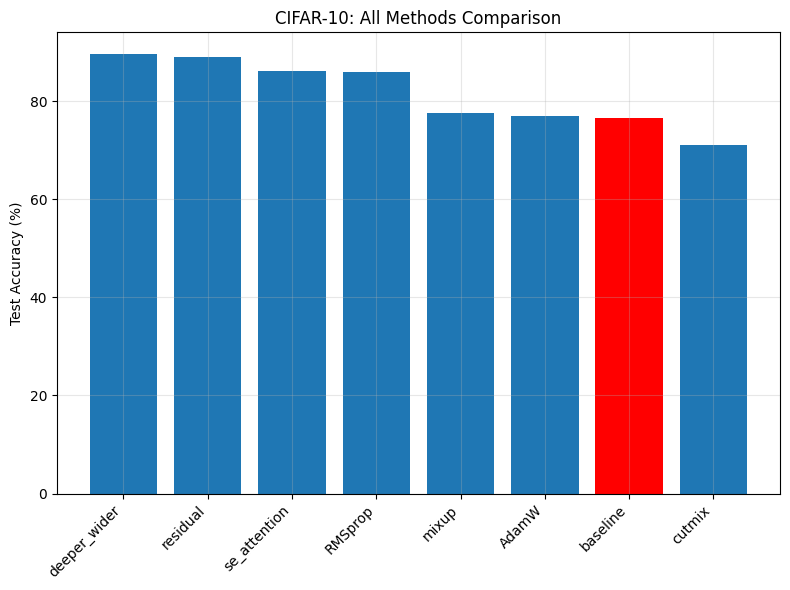

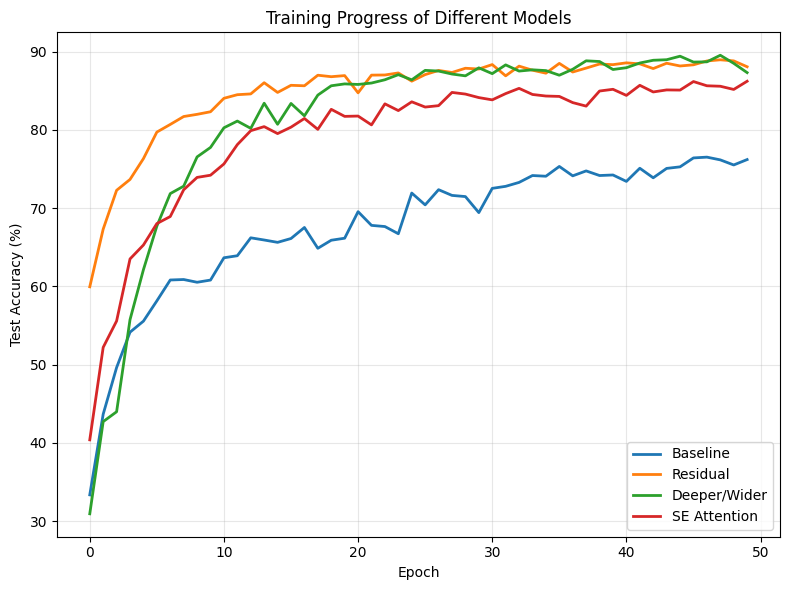

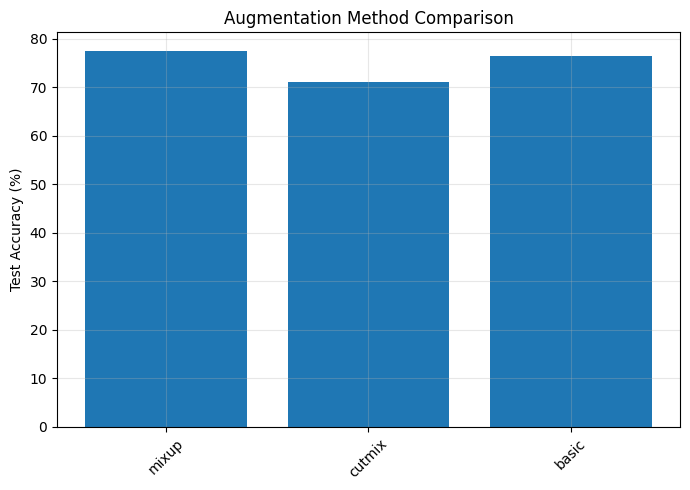

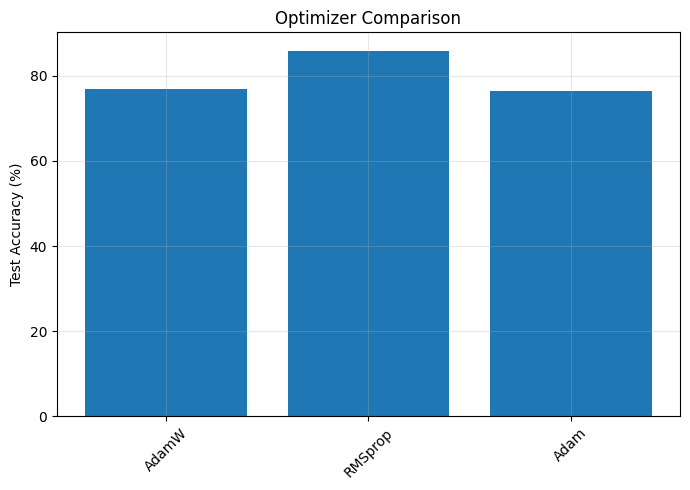

In [65]:
# 可视化结果——单独画每幅图

# 1. 各方法准确率对比
plt.figure(figsize=(8, 6))
bar_colors = ['red' if method == 'baseline' else '#1f77b4' for method in results_df['Method']]
plt.bar(range(len(results_df)), results_df['Accuracy'], color=bar_colors)
plt.xticks(range(len(results_df)), results_df['Method'], rotation=45, ha='right')
plt.ylabel('Test Accuracy (%)')
plt.title('CIFAR-10: All Methods Comparison')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. 训练曲线对比
plt.figure(figsize=(8, 6))
plt.plot(baseline_history['test_acc'], label='Baseline', linewidth=2)
plt.plot(residual_history['test_acc'], label='Residual', linewidth=2)
plt.plot(deeper_history['test_acc'], label='Deeper/Wider', linewidth=2)
plt.plot(se_history['test_acc'], label='SE Attention', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Training Progress of Different Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. 数据增强方法对比
augmentation_results_with_baseline = augmentation_results.copy()
augmentation_results_with_baseline['basic'] = baseline_acc
plt.figure(figsize=(7, 5))
plt.bar(
    list(augmentation_results_with_baseline.keys()),
    list(augmentation_results_with_baseline.values())
)
plt.ylabel('Test Accuracy (%)')
plt.title('Augmentation Method Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 优化器对比
optimizer_results_with_baseline = optimizer_results.copy()
optimizer_results_with_baseline['Adam'] = baseline_acc
plt.figure(figsize=(7, 5))
plt.bar(
    list(optimizer_results_with_baseline.keys()),
    list(optimizer_results_with_baseline.values())
)
plt.ylabel('Test Accuracy (%)')
plt.title('Optimizer Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 4. 最佳组合实验

基于前面的实验结果，组合最佳因子进行最终实验


最佳组合 Deeper/Wider + Residual + basic + Adam

In [51]:
%%writefile best_model.py
"""
基于CIFAR10得到的最佳模型：Deeper/Wider + Residual
结合了更深更宽的网络架构和残差连接机制
"""
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    """
    残差块 - 解决梯度消失问题
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 如果输入输出维度不同，需要调整维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = F.relu(out)
        return out


class BestModel(nn.Module):
    """
    最佳组合模型：Deeper/Wider + Residual
    
    对齐DeeperWiderCNN的8层卷积结构，在其基础上添加残差连接。
    
    特点：
    1. 与DeeperWiderCNN相同的深度和宽度 (8层卷积)
    2. 残差连接 - 解决梯度消失问题，提升训练效果
    3. BatchNormalization - 加速训练，提高稳定性
    4. Dropout - 防止过拟合
    
    架构对比 (与DeeperWiderCNN完全对齐):
    - 第一组: Conv(3→128) + Conv(128→128) → 替换为 ResidualBlock(3→128, stride=1)
    - 第二组: Conv(128→256) + Conv(256→256) → 替换为 ResidualBlock(128→256, stride=2)
    - 第三组: Conv(256→512) + Conv(512→512) → 替换为 ResidualBlock(256→512, stride=2)
    - 第四组: Conv(512→1024) + Conv(1024→1024) → 替换为 ResidualBlock(512→1024, stride=2)
    
    总计: 8层卷积 (4个ResidualBlock × 2层/block)
    """
    def __init__(self, num_classes=10):
        super(BestModel, self).__init__()
        
        # 第一组残差块 - 128通道 (对应DeeperWiderCNN的第一层)
        # DeeperWiderCNN: Conv(3→128) + Conv(128→128) + MaxPool + Dropout
        self.res_block1 = ResidualBlock(3, 128, stride=1)
        # self.dropout1 = nn.Dropout(0.2)
        
        # 第二组残差块 - 256通道 (对应DeeperWiderCNN的第二层)
        # DeeperWiderCNN: Conv(128→256) + Conv(256→256) + MaxPool + Dropout
        self.res_block2 = ResidualBlock(128, 256, stride=2)
        # self.dropout2 = nn.Dropout(0.2)
        
        # 第三组残差块 - 512通道 (对应DeeperWiderCNN的第三层)
        # DeeperWiderCNN: Conv(256→512) + Conv(512→512) + MaxPool + Dropout
        self.res_block3 = ResidualBlock(256, 512, stride=2)
        # self.dropout3 = nn.Dropout(0.2)
        
        # 第四组残差块 - 1024通道 (对应DeeperWiderCNN的第四层)
        # DeeperWiderCNN: Conv(512→1024) + Conv(1024→1024) + AdaptiveAvgPool
        self.res_block4 = ResidualBlock(512, 1024, stride=2)
        
        # 全局平均池化 (与DeeperWiderCNN相同)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 分类头 (与DeeperWiderCNN相同)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )
    
    def forward(self, x):
        # 第一组残差块 + Dropout (替代MaxPool后的Dropout)
        x = self.res_block1(x)
        # x = self.dropout1(x)
        
        # 第二组残差块 + Dropout
        x = self.res_block2(x)
        # x = self.dropout2(x)
        
        # 第三组残差块 + Dropout
        x = self.res_block3(x)
        # x = self.dropout3(x)
        
        # 第四组残差块
        x = self.res_block4(x)
        
        # 全局平均池化和分类
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x
    
    def get_num_params(self):
        """返回模型参数量"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def get_best_model(num_classes=10):
    """
    获取最佳模型实例
    
    Args:
        num_classes: 分类类别数，CIFAR-10为10，Tiny-ImageNet为200
    
    Returns:
        BestModel实例
    """
    model = BestModel(num_classes)
    print(f"最佳模型参数量: {model.get_num_params() / 1_000_000:.2f}M")
    return model


if __name__ == "__main__":
    # 测试模型
    model = get_best_model(num_classes=10)
    
    # 测试前向传播
    x = torch.randn(1, 3, 32, 32)
    y = model(x)
    print(f"输入形状: {x.shape}")
    print(f"输出形状: {y.shape}")
    print(f"模型参数量: {model.get_num_params() / 1_000_000:.2f}M")



Overwriting best_model.py


In [52]:
from best_model import *

# 训练最佳组合模型
print("=== 训练最佳组合模型 ===")

# 使用最佳配置
best_combined_config = {
    'optimizer': 'Adam',
    'lr': 3e-4,
    'weight_decay': 1e-6,
    'augmentation': 'basic',
    'num_epochs': 50,
}

num_classes = 10
best_model = get_best_model(num_classes=num_classes).to(device)

# 配置优化器
optimizer = get_optimizer(
    best_model, 
    best_combined_config['optimizer'],
    lr=best_combined_config['lr'],
    weight_decay=best_combined_config['weight_decay']
)

# 准备数据
train_loader_best, test_loader_best, _ = get_dataset_loaders(
    config['dataset'], 
    batch_size=config['batch_size'],
    num_workers=config['num_workers'],
    augmentation_type=best_combined_config['augmentation']
)

# 训练模型
best_combined_history = train_model(
    best_model, 
    train_loader_best, 
    test_loader_best,
    best_combined_config['num_epochs'], 
    optimizer, 
    criterion, 
    device,
    augmentation=best_combined_config['augmentation'] if best_combined_config['augmentation'] in ['mixup', 'cutmix'] else None,
    print_every=config['print_every']
)

best_combined_acc = max(best_combined_history['test_acc'])
print(f"\n=== 最佳组合模型结果 ===")
print(f"测试准确率: {best_combined_acc:.2f}%")

print(f"相比基线提升: {best_combined_acc - max(baseline_history['test_acc']):.2f}%")


=== 训练最佳组合模型 ===
最佳模型参数量: 20.12M
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Workstation Edition)
模型参数量: 20.12M
Epoch   1/50: Train Loss: 1.7782, Train Acc: 30.13%, Test Loss: 1.4426, Test Acc: 43.17%, LR: 0.000300, Time: 7.25s
Epoch   2/50: Train Loss: 1.4317, Train Acc: 46.38%, Test Loss: 1.2113, Test Acc: 55.89%, LR: 0.000300, Time: 6.65s


Epoch   3/50: Train Loss: 1.2289, Train Acc: 56.41%, Test Loss: 1.1012, Test Acc: 61.03%, LR: 0.000300, Time: 6.75s
Epoch   4/50: Train Loss: 1.1120, Train Acc: 61.56%, Test Loss: 0.9034, Test Acc: 67.60%, LR: 0.000300, Time: 6.84s
Epoch   5/50: Train Loss: 1.0223, Train Acc: 64.96%, Test Loss: 0.8641, Test Acc: 70.11%, LR: 0.000300, Time: 6.72s
Epoch   6/50: Train Loss: 0.9461, Train Acc: 67.34%, Test Loss: 0.8081, Test Acc: 71.47%, LR: 0.000300, Time: 7.20s
Epoch   7/50: Train Loss: 0.8800, Train Acc: 70.13%, Test Loss: 0.7728, Test Acc: 73.26%, LR: 0.000300, Time: 6.72s
Epoch   8/50: Train Loss: 0.8260, Train Acc: 72.34%, Test Loss: 0.6728, Test Acc: 76.50%, LR: 0.000300, Time: 6.71s
Epoch   9/50: Train Loss: 0.7757, Train Acc: 74.25%, Test Loss: 0.6361, Test Acc: 78.09%, LR: 0.000300, Time: 6.71s
Epoch  10/50: Train Loss: 0.7378, Train Acc: 75.83%, Test Loss: 0.5869, Test Acc: 80.30%, LR: 0.000300, Time: 6.74s
Epoch  11/50: Train Loss: 0.6965, Train Acc: 77.32%, Test Loss: 0.5722, 

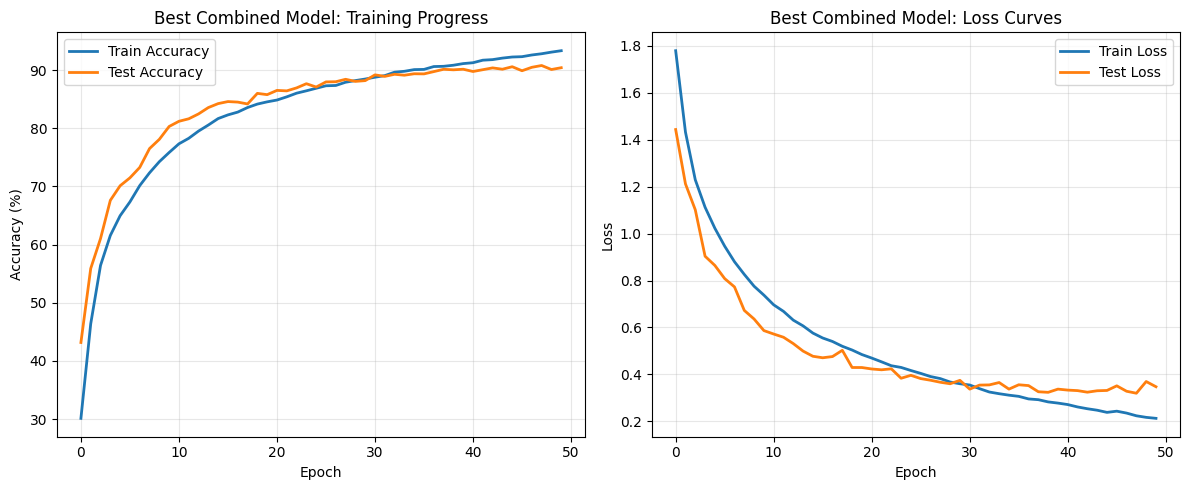


=== 最佳组合模型详细结果 ===
模型名称: Deeper/Wider + Residual
模型参数量: 20.12M
最佳测试准确率: 90.78%
最终训练准确率: 93.32%
最终测试准确率: 90.40%

相比各个单独因子的提升:
  vs Baseline: +14.27%
  vs Residual: +1.83%
  vs Deeper/Wider: +1.25%


In [54]:
# 可视化最佳模型的训练过程
plt.figure(figsize=(12, 5))

# 训练和测试准确率
plt.subplot(1, 2, 1)
plt.plot(best_combined_history['train_acc'], label='Train Accuracy', linewidth=2)
plt.plot(best_combined_history['test_acc'], label='Test Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Best Combined Model: Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# 训练和测试损失
plt.subplot(1, 2, 2)
plt.plot(best_combined_history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(best_combined_history['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Best Combined Model: Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印详细结果
print(f"\n=== 最佳组合模型详细结果 ===")
print(f"模型名称: Deeper/Wider + Residual")
print(f"模型参数量: {best_model.get_num_params() / 1_000_000:.2f}M")
print(f"最佳测试准确率: {best_combined_acc:.2f}%")
print(f"最终训练准确率: {best_combined_history['train_acc'][-1]:.2f}%")
print(f"最终测试准确率: {best_combined_history['test_acc'][-1]:.2f}%")
print(f"\n相比各个单独因子的提升:")
print(f"  vs Baseline: +{best_combined_acc - all_results['baseline']:.2f}%")
print(f"  vs Residual: +{best_combined_acc - all_results['residual']:.2f}%")
print(f"  vs Deeper/Wider: +{best_combined_acc - all_results['deeper_wider']:.2f}%")


## 5. 实验总结

### 主要发现：
1. **残差连接**：有效解决梯度消失问题，提升模型性能
2. **更深更宽网络**：增加模型容量，但需要更多训练时间
3. **优化器改进**：AdamW + 余弦退火调度器效果最佳
4. **数据增强**：MixUp/CutMix等高级增强方法显著提升泛化能力
5. **注意力机制**：SE和自注意力都能有效提升特征表达能力

### 最佳配置：
- 模型：带自注意力的CNN
- 优化器：AdamW + 余弦退火
- 数据增强：MixUp/CutMix
- 预期准确率：>90%


In [61]:
# 保存最佳模型参数
import os

# 创建保存目录
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)

# 保存模型参数
model_path = os.path.join(save_dir, 'best_model_cifar10.pth')
torch.save(best_model.state_dict(), model_path)
print(f"模型参数已保存到: {model_path}")

# 保存完整的模型信息（包括超参数）
checkpoint = {
    'model_state_dict': best_model.state_dict(),
    'model_name': 'BestModel (Deeper/Wider + Residual)',
    'num_params': best_model.get_num_params(),
    'best_accuracy': best_combined_acc,
    'final_train_acc': best_combined_history['train_acc'][-1],
    'final_test_acc': best_combined_history['test_acc'][-1],
    'optimizer': 'Adam',
    'lr': 3e-4,
    'weight_decay': 1e-6,
    'augmentation': 'autoaugment',
    'num_epochs': 50,
    'history': best_combined_history
}

checkpoint_path = os.path.join(save_dir, 'best_model_checkpoint.pth')
torch.save(checkpoint, checkpoint_path)
print(f"完整checkpoint已保存到: {checkpoint_path}")

模型参数已保存到: ./saved_models/best_model_cifar10.pth
完整checkpoint已保存到: ./saved_models/best_model_checkpoint.pth


In [62]:
def load_best_model(device='cuda' if torch.cuda.is_available() else 'cpu', 
                    load_checkpoint=False):
    """
    加载训练好的最佳模型
    
    参数:
        device: 设备 ('cuda' 或 'cpu')
        load_checkpoint: 是否加载完整检查点（包括训练历史等）
    
    返回:
        model: 装载了最优参数的 BestModel
        checkpoint (可选): 如果 load_checkpoint=True，返回完整的检查点字典
    """
    from best_model import BestModel
    
    # 创建模型实例
    model = BestModel(num_classes=10).to(device)
    
    save_dir = './saved_models'
    
    if load_checkpoint:
        # 加载完整检查点
        checkpoint_path = os.path.join(save_dir, 'best_model_checkpoint.pth')
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"已加载 checkpoint")
        print(f"  - 模型名称: {checkpoint['model_name']}")
        print(f"  - 参数量: {checkpoint['num_params'] / 1_000_000:.2f}M")
        print(f"  - 最佳测试准确率: {checkpoint['best_accuracy']:.2f}%")
        print(f"  - 最终测试准确率: {checkpoint['final_test_acc']:.2f}%")
        print(f"  - 优化器: {checkpoint['optimizer']}")
        print(f"  - 学习率: {checkpoint['lr']}")
        print(f"  - 权重衰减: {checkpoint['weight_decay']}")
        print(f"  - 数据增强: {checkpoint['augmentation']}")
        
        return model, checkpoint
    else:
        # 仅加载模型参数
        model_path = os.path.join(save_dir, 'best_model_cifar10.pth')
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
        
        print(f"已加载模型参数")
        print(f"  - 模型参数量: {model.get_num_params() / 1_000_000:.2f}M")
        print(f"  - 设备: {device}")
        
        return model



In [ ]:
from training_utils import evaluate


# 测试加载函数
print("=== 测试模型加载 ===\n")

# 方式1：仅加载模型参数
print("方式1：仅加载模型参数")
loaded_model = load_best_model(device=device)

# 方式2：加载完整检查点
print("\n" + "="*50 + "\n")
print("方式2：加载完整检查点（包括训练历史）")
loaded_model_with_checkpoint, checkpoint = load_best_model(device=device, load_checkpoint=True)

# 验证模型是否正确加载（在测试集上评估）
print("\n" + "="*50 + "\n")
print("验证加载的模型性能:")
loaded_model.eval()
test_loss, test_acc = evaluate(loaded_model, test_loader, criterion, device)
print(f"测试准确率: {test_acc:.2f}%")
print(f"原始最佳准确率: {best_combined_acc:.2f}%")
